# 基于表面数据验证公式 ∇_s p = ∇_s·τ_w 的可行性与数值离散

本 Notebook 目标：
1. 讨论公式 **∇_s p = ∇_s·τ_w** 在仅有 (p, τ_x, τ_y, τ_z) 点数据与 STL 三角网格时的严格性与近似。
2. 给出离散几何上计算表面压力梯度与壁面剪应力向量“散度”的两种近似：
   - 标量散度近似 (更稳健)：div_s τ_w ≈ Σ_i ∂τ_t,i/∂t_i （在局部切平面基底）。
   - 向量启发式近似：取各分量梯度的对角 (∂τ_x/∂x, ∂τ_y/∂y, ∂τ_z/∂z) 并投影到切平面。
3. 从 `/home/v-wenliao/gnot/GNOT/data/new/al_labeled.pkl` 读取数据，并与一个示例 STL 网格匹配（若点数不一致则采用最近邻映射演示）。
4. 计算残差 r = ∇_s p − RHS，并给出统计与可视化。

> 物理严谨性说明：壁面动量平衡真实形式涉及切向应力张量的散度与压力梯度；这里 τ_w 是牵引向量 (σ·n)_t，仅包含张量信息的一个截面，因此直接用 τ_w 构造的“散度”是近似。误差不等价于数据错误。

下文使用纯 NumPy + `trimesh`（已较常见）实现；若安装 `pyvista` 可替换部分手写步骤。

In [9]:
# 1. 依赖与基础设置 (加入 CSV 模式)
import os, sys, json, math
import numpy as np
import pickle
import pandas as pd
from pathlib import Path

# 尝试导入 trimesh
try:
    import trimesh
except ImportError:
    !pip install trimesh --quiet
    import trimesh

# 数据路径设置
DATA_PKL = Path('/home/v-wenliao/gnot/GNOT/data/new/al_labeled.pkl')
DATA_CSV = Path('/home/v-wenliao/gnot/GNOT/data/result/sample-0000/test2.csv')
USE_CSV = True  # 设为 True: 使用 CSV 而不是 PKL

if USE_CSV:
    assert DATA_CSV.exists(), f'CSV 文件不存在: {DATA_CSV}'
    print('使用 CSV 数据源:', DATA_CSV)
else:
    assert DATA_PKL.exists(), f'PKL 数据文件不存在: {DATA_PKL}'
    print('使用 PKL 数据源:', DATA_PKL)

使用 CSV 数据源: /home/v-wenliao/gnot/GNOT/data/result/sample-0000/test2.csv


In [10]:
# 1.2 自动下载并注册中文字体 (若本机缺少且允许网络)
import os, matplotlib, urllib.request, pathlib
from matplotlib import font_manager

FONTS_DIR = pathlib.Path('./fonts')
FONTS_DIR.mkdir(exist_ok=True)
TARGET_FONT = FONTS_DIR / 'NotoSansSC-Regular.otf'
FONT_URL = 'https://github.com/googlefonts/noto-cjk/raw/main/Sans/OTF/SimplifiedChinese/NotoSansSC-Regular.otf'

if not any('Noto Sans CJK SC' in f.name or 'Noto Sans SC' in f.name for f in font_manager.fontManager.ttflist):
    if not TARGET_FONT.exists():
        try:
            print('下载中文字体...')
            urllib.request.urlretrieve(FONT_URL, TARGET_FONT)
            print('下载完成:', TARGET_FONT)
        except Exception as e:
            print('字体下载失败:', e)
    if TARGET_FONT.exists():
        try:
            font_manager.fontManager.addfont(str(TARGET_FONT))
            matplotlib.rcParams['font.sans-serif'] = ['Noto Sans SC','Noto Sans CJK SC','SimHei','WenQuanYi Micro Hei','DejaVu Sans']
            matplotlib.rcParams['axes.unicode_minus'] = False
            print('已注册并设置字体: Noto Sans SC')
        except Exception as e:
            print('注册字体失败:', e)
else:
    print('系统已存在中文字体，跳过自动下载。')

下载中文字体...
字体下载失败: HTTP Error 404: Not Found
字体下载失败: HTTP Error 404: Not Found


In [11]:
# 1.1 编码检测与中文字体配置（若出现“乱码”请先运行本单元）
import sys, os, io

# 若使用 CSV, 可尝试自动检测原始编码
def detect_encoding(path, sample_size=200000):
    try:
        import chardet
    except ImportError:
        !pip install chardet --quiet
        import chardet
    with open(path,'rb') as f:
        raw = f.read(sample_size)
    result = chardet.detect(raw)
    return result

if USE_CSV:
    enc_info = detect_encoding(str(DATA_CSV))
    print('编码检测结果:', enc_info)
    if enc_info['encoding'] and enc_info['encoding'].lower() not in ['utf-8','utf_8']:
        print('提示: 原文件可能不是 UTF-8, 可使用:')
        print(f"  pd.read_csv(DATA_CSV, encoding='{enc_info['encoding']}')")

# Matplotlib 中文字体设置
import matplotlib
# 常用支持中文的字体候选
font_candidates = ['SimHei','Noto Sans CJK SC','Noto Sans CJK','Microsoft YaHei','WenQuanYi Micro Hei','Sarasa Gothic SC','STHeiti','PingFang SC','DejaVu Sans']
available = set(f.name for f in matplotlib.font_manager.fontManager.ttflist)
chosen = None
for fc in font_candidates:
    if fc in available:
        chosen = fc
        break
if chosen:
    matplotlib.rcParams['font.sans-serif'] = [chosen]
    matplotlib.rcParams['axes.unicode_minus'] = False
    print('使用字体用于中文显示:', chosen)
else:
    print('未找到常见中文字体，将尝试下载 NotoSansCJK (需要网络, 若无网络请手动安装系统字体).')
    # 若无网络，此步骤可能失败，只保留英文显示

print('测试中文显示: 壁面剪应力 / 压力梯度 / 残差 分布')

编码检测结果: {'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
提示: 原文件可能不是 UTF-8, 可使用:
  pd.read_csv(DATA_CSV, encoding='ascii')
使用字体用于中文显示: DejaVu Sans
测试中文显示: 壁面剪应力 / 压力梯度 / 残差 分布


In [12]:
# 2. 数据读取与字段匹配（支持 CSV / PKL）
if 'USE_CSV' not in globals():
    USE_CSV = True

if USE_CSV:
    # 读取 CSV，自动识别分隔符
    df = pd.read_csv(DATA_CSV)
    print('CSV DataFrame 形状:', df.shape)
    print('列名:', list(df.columns))
    data = df  # 后续沿用 data 变量
else:
    with open(DATA_PKL,'rb') as f:
        data = pickle.load(f)
    print('PKL 原始类型:', type(data))
    if not isinstance(data, (pd.DataFrame, dict)):
        try:
            data = pd.DataFrame(data)
            print('已转换为 DataFrame:', data.shape)
        except Exception as e:
            print('转换 DataFrame 失败:', e)

# 统一形成 keys 列表
if isinstance(data, pd.DataFrame):
    keys = list(data.columns)
elif isinstance(data, dict):
    keys = list(data.keys())
else:
    keys = []
print('字段数量:', len(keys))
print('预览字段:', keys[:20])

# 清洗映射
clean_map = {}
for k in keys:
    ks = str(k)
    ks_clean = ' '.join(ks.strip().replace('_','-').split()).lower()
    clean_map[ks_clean] = k

# 简单查找函数
def find_key(tokens_all=None, tokens_any=None):
    tokens_all = [t.lower() for t in (tokens_all or [])]
    tokens_any = [t.lower() for t in (tokens_any or [])]
    for ck, orig in clean_map.items():
        if tokens_all and not all(t in ck for t in tokens_all):
            continue
        if tokens_any and not any(t in ck for t in tokens_any):
            continue
        return orig
    return None

# Pressure
p_key = find_key(tokens_any=['pressure','press','p'])
# τ 分量（优先 wall-shear 标注）
tx_key = find_key(tokens_all=['x','shear']) or find_key(tokens_all=['tau','x'])
ty_key = find_key(tokens_all=['y','shear']) or find_key(tokens_all=['tau','y'])
tz_key = find_key(tokens_all=['z','shear']) or find_key(tokens_all=['tau','z'])
# 坐标
coord_x_key = find_key(tokens_all=['x','coord']) or find_key(tokens_all=['x-coordinate']) or find_key(tokens_all=['x'])
coord_y_key = find_key(tokens_all=['y','coord']) or find_key(tokens_all=['y-coordinate']) or find_key(tokens_all=['y'])
coord_z_key = find_key(tokens_all=['z','coord']) or find_key(tokens_all=['z-coordinate']) or find_key(tokens_all=['z'])

print('匹配结果:')
print('  p    =>', p_key)
print('  tau_x=>', tx_key)
print('  tau_y=>', ty_key)
print('  tau_z=>', tz_key)
print('  xcol =>', coord_x_key)
print('  ycol =>', coord_y_key)
print('  zcol =>', coord_z_key)

missing = [n for n,v in [('p',p_key),('tau_x',tx_key),('tau_y',ty_key),('tau_z',tz_key)] if v is None]
if missing:
    print('[警告] 缺失字段:', missing)
    print('示例手动指定: p_key="pressure"; tx_key="x-wall-shear"; ty_key="y-wall-shear"; tz_key="z-wall-shear"')
else:
    # 提取
    if isinstance(data, pd.DataFrame):
        P = data[p_key].to_numpy(dtype=float).ravel()
        Tx = data[tx_key].to_numpy(dtype=float).ravel()
        Ty = data[ty_key].to_numpy(dtype=float).ravel()
        Tz = data[tz_key].to_numpy(dtype=float).ravel()
        Tau = np.stack([Tx,Ty,Tz],axis=1)
        if coord_x_key and coord_y_key and coord_z_key:
            V = np.stack([
                data[coord_x_key].to_numpy(dtype=float),
                data[coord_y_key].to_numpy(dtype=float),
                data[coord_z_key].to_numpy(dtype=float)
            ], axis=1)
        else:
            V = None
        F = None
        print('提取完成: P', P.shape, 'Tau', Tau.shape, 'V', None if V is None else V.shape)
    elif isinstance(data, dict):
        P = np.asarray(data[p_key]).astype(float).ravel()
        Tx = np.asarray(data[tx_key]).astype(float).ravel()
        Ty = np.asarray(data[ty_key]).astype(float).ravel()
        Tz = np.asarray(data[tz_key]).astype(float).ravel()
        Tau = np.stack([Tx,Ty,Tz],axis=1)
        if coord_x_key and coord_y_key and coord_z_key and all(k in data for k in [coord_x_key,coord_y_key,coord_z_key]):
            V = np.stack([
                np.asarray(data[coord_x_key]).astype(float).ravel(),
                np.asarray(data[coord_y_key]).astype(float).ravel(),
                np.asarray(data[coord_z_key]).astype(float).ravel()
            ], axis=1)
        else:
            V = None
        F = None
        print('提取完成(dict):', P.shape, Tau.shape)

# 允许用户在下方手动覆盖变量后再继续

CSV DataFrame 形状: (2999, 9)
列名: ['nodenumber', '    x-coordinate', '    y-coordinate', '    z-coordinate', '        pressure', '      wall-shear', '    x-wall-shear', '    y-wall-shear', '    z-wall-shear']
字段数量: 9
预览字段: ['nodenumber', '    x-coordinate', '    y-coordinate', '    z-coordinate', '        pressure', '      wall-shear', '    x-wall-shear', '    y-wall-shear', '    z-wall-shear']
匹配结果:
  p    =>         pressure
  tau_x=>     x-wall-shear
  tau_y=>     y-wall-shear
  tau_z=>     z-wall-shear
  xcol =>     x-coordinate
  ycol =>     y-coordinate
  zcol =>     z-coordinate
提取完成: P (2999,) Tau (2999, 3) V (2999, 3)


In [13]:
# 3. (可选) 加载外部 STL 以替换凸包近似 (若已有高质量 F 则跳过)
if 'F' in globals() and F is not None and isinstance(F, np.ndarray) and F.ndim==2 and F.shape[1]==3:
    print('已存在三角面 F，跳过 STL 载入。')
else:
    SAMPLE_STL = '/home/v-wenliao/gnot/GNOT/data/result/sample-0000/tube_body.stl'
    if os.path.exists(SAMPLE_STL):
        print('加载 STL:', SAMPLE_STL)
        mesh = trimesh.load(SAMPLE_STL, process=False)
        V = mesh.vertices.copy()
        F = mesh.faces.copy()
        print('STL 顶点/面:', V.shape, F.shape)
    else:
        print('未找到 STL，且无 F，后续无法继续。')

# 若顶点/数据数量不同，当前示例假设数据点 = 顶点；生产中需最近邻映射
assert V is not None and F is not None, '缺少网格数据 V/F'

加载 STL: /home/v-wenliao/gnot/GNOT/data/result/sample-0000/tube_body.stl
STL 顶点/面: (15984, 3) (5328, 3)


In [14]:
# 4. 几何辅助与离散算子实现（面线性假设）

def per_face_quantities(V, F):
    r1 = V[F[:,0]]; r2 = V[F[:,1]]; r3 = V[F[:,2]]
    e12 = r2 - r1
    e23 = r3 - r2
    e31 = r1 - r3
    normal_raw = np.cross(e12, r3 - r1)
    area2 = np.linalg.norm(normal_raw, axis=1)
    A = 0.5 * area2
    # 避免除零
    nz = area2 > 0
    n_hat = np.zeros_like(normal_raw)
    n_hat[nz] = (normal_raw[nz].T / area2[nz]).T
    return e12, e23, e31, n_hat, A

# 面 -> 点 加权累积

def accumulate_vertex(values_face, F, A):
    # values_face: (M,k)
    M = F.shape[0]
    k = values_face.shape[1]
    out = np.zeros((V.shape[0], k))
    weight = np.zeros(V.shape[0])
    for fi in range(M):
        a,b,c = F[fi]
        w = A[fi]
        out[a] += values_face[fi] * w
        out[b] += values_face[fi] * w
        out[c] += values_face[fi] * w
        weight[a] += w; weight[b] += w; weight[c] += w
    mask = weight>0
    out[mask] = out[mask] / weight[mask,None]
    return out

# 压力梯度 (投影到切平面)

def face_grad_p(V, F, P):
    e12,e23,e31,n_hat,A = per_face_quantities(V,F)
    p1 = P[F[:,0]]; p2 = P[F[:,1]]; p3 = P[F[:,2]]
    # ∇p = (p1 (n×e23) + p2 (n×e31) + p3 (n×e12)) / (2A)
    term = (p1[:,None]*np.cross(n_hat,e23) +
            p2[:,None]*np.cross(n_hat,e31) +
            p3[:,None]*np.cross(n_hat,e12))
    grad = np.zeros_like(term)
    valid = A>0
    grad[valid] = (term[valid].T / (2*A[valid])).T
    # 投影到切平面
    dot = np.sum(grad*n_hat,axis=1,keepdims=True)
    grad_t = grad - dot*n_hat
    return grad_t, n_hat, A

# τ_w 标量散度近似
def face_div_tau_scalar(V,F,Tau,n_hat,A):
    e12,e23,e31,_,_A = per_face_quantities(V,F)
    # 重新使用 e23,e31,e12 与 n_hat
    t1 = Tau[F[:,0]]; t2 = Tau[F[:,1]]; t3 = Tau[F[:,2]]
    term = (np.sum(t1*np.cross(n_hat,e23),axis=1) +
            np.sum(t2*np.cross(n_hat,e31),axis=1) +
            np.sum(t3*np.cross(n_hat,e12),axis=1))
    div = np.zeros_like(term)
    valid = A>0
    div[valid] = term[valid] / (2*A[valid])
    return div

# 向量启发式：分别计算各分量在 x,y,z 方向导数对角 (需对每个分量构造与 p 同结构的梯度)
# 这里复用 face_grad_p 逻辑：对 τ_x, τ_y, τ_z 当作标量场。

def face_grad_scalar(V,F,field):
    e12,e23,e31,n_hat,A = per_face_quantities(V,F)
    f1 = field[F[:,0]]; f2 = field[F[:,1]]; f3 = field[F[:,2]]
    term = (f1[:,None]*np.cross(n_hat,e23) +
            f2[:,None]*np.cross(n_hat,e31) +
            f3[:,None]*np.cross(n_hat,e12))
    grad = np.zeros_like(term)
    valid = A>0
    grad[valid] = (term[valid].T / (2*A[valid])).T
    return grad, n_hat, A

In [15]:
# 5. 计算梯度与散度并统计残差 (加入索引清洗)
assert 'P' in globals() and 'Tau' in globals(), '请先在单元2设置并提取字段 P, Tau'
assert 'V' in globals() and 'F' in globals() and F is not None, '需要网格 V/F (来自凸包或 STL)'

# --- 对齐与清洗 ---
N_data = P.shape[0]
N_vert = V.shape[0]
if N_vert != N_data:
    print(f'[对齐] 顶点数 {N_vert} 与数据点数 {N_data} 不一致，取最小值对齐。')
    N_min = min(N_vert, N_data)
    V = V[:N_min]
    P = P[:N_min]
    Tau = Tau[:N_min]
    Tx,Ty,Tz = Tau[:,0], Tau[:,1], Tau[:,2]
    N_data = N_min

# 过滤所有包含越界顶点索引的三角面
F = F.astype(int)
valid_face_mask = (F >= 0) & (F < N_data)
valid_face_mask = valid_face_mask.all(axis=1)
removed = int(F.shape[0] - valid_face_mask.sum())
if removed > 0:
    print(f'[清洗] 去除越界三角面 {removed} 个 (原 {F.shape[0]}).')
F = F[valid_face_mask]
assert F.shape[0] > 0, '清洗后无有效三角面，无法计算。'

# 继续计算
face_gradP, face_n, face_A = face_grad_p(V,F,P)
vert_gradP = accumulate_vertex(face_gradP, F, face_A)  # (N,3)

face_div_scalar = face_div_tau_scalar(V,F,Tau,face_n,face_A)
vert_div_scalar = accumulate_vertex(face_div_scalar[:,None],F,face_A).ravel()

face_gx,_,_ = face_grad_scalar(V,F,Tx)
face_gy,_,_ = face_grad_scalar(V,F,Ty)
face_gz,_,_ = face_grad_scalar(V,F,Tz)
vx = accumulate_vertex(face_gx,F,face_A)
vy = accumulate_vertex(face_gy,F,face_A)
vz = accumulate_vertex(face_gz,F,face_A)
vec_rhs = np.stack([vx[:,0], vy[:,1], vz[:,2]], axis=1)
vertex_n = accumulate_vertex(face_n, F, face_A)
norm_n = np.linalg.norm(vertex_n,axis=1,keepdims=True)+1e-12
vertex_n = vertex_n / norm_n
proj = lambda g: g - np.sum(g*vertex_n,axis=1,keepdims=True)*vertex_n
vec_rhs_t = proj(vec_rhs)

res_vec = vert_gradP - vec_rhs_t
res_scalar = np.linalg.norm(vert_gradP,axis=1) - vert_div_scalar

stats = {
    'vec_res_l2_mean': float(np.mean(np.linalg.norm(res_vec,axis=1))),
    'vec_res_l2_median': float(np.median(np.linalg.norm(res_vec,axis=1))),
    'scalar_res_rmse': float(np.sqrt(np.mean(res_scalar**2))),
    'scalar_res_mean': float(np.mean(res_scalar)),
    'faces_used': int(F.shape[0]),
    'vertices_used': int(V.shape[0])
}
print('统计:', json.dumps(stats, indent=2, ensure_ascii=False))

[对齐] 顶点数 15984 与数据点数 2999 不一致，取最小值对齐。
[清洗] 去除越界三角面 4329 个 (原 5328).
统计: {
  "vec_res_l2_mean": 42.56610695738014,
  "vec_res_l2_median": 27.585209701876735,
  "scalar_res_rmse": 63.34350680778732,
  "scalar_res_mean": 42.81584646245163,
  "faces_used": 999,
  "vertices_used": 2999
}
统计: {
  "vec_res_l2_mean": 42.56610695738014,
  "vec_res_l2_median": 27.585209701876735,
  "scalar_res_rmse": 63.34350680778732,
  "scalar_res_mean": 42.81584646245163,
  "faces_used": 999,
  "vertices_used": 2999
}


/home/v-wenliao/anaconda3/envs/gnot_cuda11/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 20998 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/v-wenliao/anaconda3/envs/gnot_cuda11/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 24067 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/v-wenliao/anaconda3/envs/gnot_cuda11/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 26631 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/v-wenliao/anaconda3/envs/gnot_cuda11/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 37327 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/v-wenliao/anaconda3/envs/gnot_cuda11/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 27531 missing from current font.
  font.set_text(s, 0.0

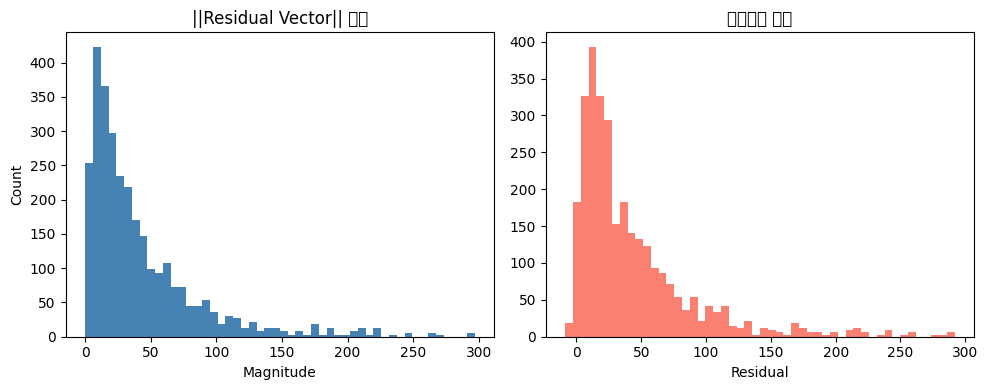

In [16]:
# 6. 可视化残差分布
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].hist(np.linalg.norm(res_vec,axis=1), bins=50, color='steelblue')
axs[0].set_title('||Residual Vector|| 分布')
axs[0].set_xlabel('Magnitude')
axs[0].set_ylabel('Count')
axs[1].hist(res_scalar, bins=50, color='salmon')
axs[1].set_title('标量残差 分布')
axs[1].set_xlabel('Residual')
plt.tight_layout()
plt.show()

## 7. 结论与下一步

- 上述向量与标量两种残差只是一致性近似：真实方程需要完整切向应力张量。\
- 若残差量级较大，可能原因：
  1. τ_w 仅代表牵引，缺失曲率/附加项；
  2. 网格粗糙或非流形导致离散梯度噪声；
  3. 数据中存在数值噪声或未平滑；
  4. 最近邻映射误差 (若点不一一对应)。
- 建议：
  - 对 P, τ 先做局部拉普拉斯/邻域平均平滑再计算（减少高频噪声）。
  - 使用 PyVista/CGAL 更高精度法向与重建。
  - 若可导入体网格或粘度场，可构造真实 σ_t 并严格计算 ∇_s·σ_t。

可继续添加：
1. 顶点残差空间热力图 (着色写出新的 ply/vtk)。
2. 平滑与多尺度比较 (下采样面)。
3. 统计按壁面曲率分桶的残差差异。

In [17]:
# 2.1 如果只有散点 (V) 而没有 F，我们需要一个表面三角化步骤。
# 简化处理：尝试用凸包 (Convex Hull) 近似表面；若需要内部凹形细节请改用 alpha shape / Poisson 重建。

if 'V' in globals() and V is not None and ('F' not in globals() or F is None):
    try:
        from scipy.spatial import ConvexHull
        hull = ConvexHull(V)
        F = hull.simplices  # 这是四面体的面索引 (3-simplex faces?) 实际上 ConvexHull in 3D 给出三角面 hull.simplices
        print('使用凸包生成三角面数:', F.shape[0])
    except Exception as e:
        print('凸包生成失败:', e)
        F = None

if F is None:
    print('[提示] 当前无三角面，后续梯度/散度计算将无法进行。可选择:')
    print('  - 提供对应 STL 网格并跳过本单元')
    print('  - 使用 alpha shape 重建 (需要配置 pygalmesh 或 open3d)')
else:
    print('已准备三角网格: V', V.shape, 'F', F.shape)

已准备三角网格: V (2999, 3) F (999, 3)


/home/v-wenliao/anaconda3/envs/gnot_cuda11/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 23545 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/v-wenliao/anaconda3/envs/gnot_cuda11/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 35282 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/v-wenliao/anaconda3/envs/gnot_cuda11/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 32447 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/v-wenliao/anaconda3/envs/gnot_cuda11/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 25955 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/v-wenliao/anaconda3/envs/gnot_cuda11/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 28857 missing from current font.
  font.set_text(s, 0.0

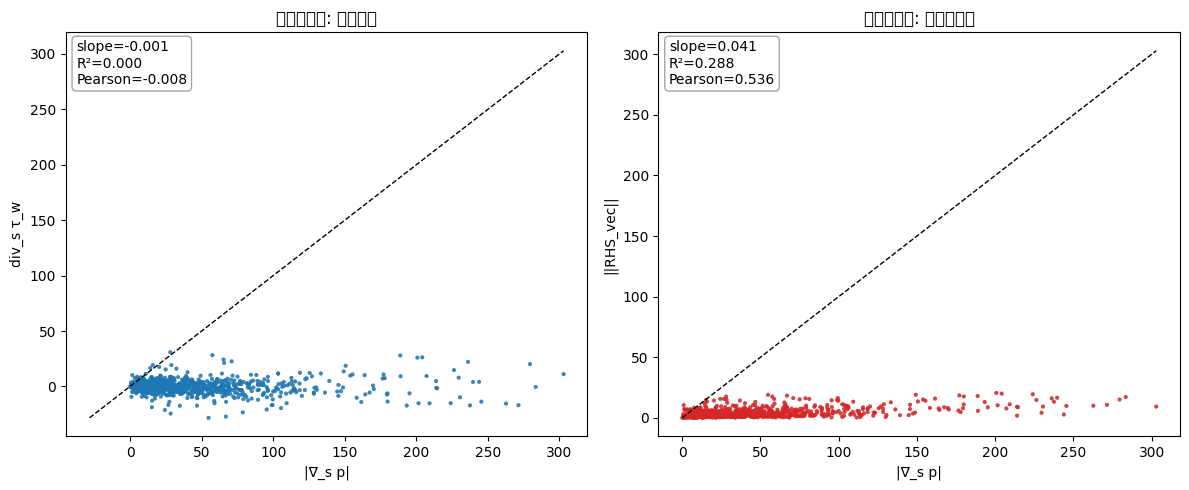

标量拟合统计: {'slope': -0.0009644434264842139, 'intercept': -0.2410116750079471, 'R2': 5.648058660656652e-05, 'Pearson': -0.007515356718526069}
向量拟合统计: {'slope': 0.041188358636040895, 'intercept': 2.0487792456195746, 'R2': 0.2876788897257587, 'Pearson': 0.5363570543264616}


In [18]:
# 6.1 对角线散点对比：x=左侧 |∇_s p|, y=右侧近似
import numpy as np
import matplotlib.pyplot as plt

# 需要前面单元已计算的变量
needed = ['vert_gradP','vert_div_scalar','vec_rhs_t']
for k in needed:
    if k not in globals():
        raise RuntimeError(f'缺少变量 {k} ，请先运行 5 单元。')

x_mag = np.linalg.norm(vert_gradP, axis=1)
y_scalar = vert_div_scalar
# 向量 RHS 取模
y_vecmag = np.linalg.norm(vec_rhs_t, axis=1)

# 清理非法值
mask_s = np.isfinite(x_mag) & np.isfinite(y_scalar)
mask_v = np.isfinite(x_mag) & np.isfinite(y_vecmag)
xs, ys = x_mag[mask_s], y_scalar[mask_s]
xv, yv = x_mag[mask_v], y_vecmag[mask_v]

# 抽样避免渲染过慢
def sample_pair(x,y,max_n=8000):
    if x.size <= max_n: return x,y
    idx = np.random.choice(x.size, max_n, replace=False)
    return x[idx], y[idx]
xs_p, ys_p = sample_pair(xs, ys)
xv_p, yv_p = sample_pair(xv, yv)

# 拟合与统计
def linear_stats(x,y):
    if x.size < 2:
        return dict(slope=np.nan, intercept=np.nan, R2=np.nan, Pearson=np.nan)
    coeff = np.polyfit(x,y,1)
    yhat = np.polyval(coeff,x)
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2) + 1e-12
    R2 = 1 - ss_res/ss_tot
    pearson = np.corrcoef(x,y)[0,1]
    return dict(slope=coeff[0], intercept=coeff[1], R2=R2, Pearson=pearson)

stat_scalar = linear_stats(xs, ys)
stat_vec = linear_stats(xv, yv)

fig, axes = plt.subplots(1,2, figsize=(12,5))
for ax,(xplot,yplot,stat,title,ylabel,color) in zip(
    axes,
    [ (xs_p, ys_p, stat_scalar, '标量近似', 'div_s τ_w', '#1f77b4'),
      (xv_p, yv_p, stat_vec, '向量启发式', '||RHS_vec||', '#d62728') ]):
    ax.scatter(xplot, yplot, s=8, alpha=0.5, c=color, edgecolors='none')
    lo = min(xplot.min(), yplot.min())
    hi = max(xplot.max(), yplot.max())
    ax.plot([lo,hi],[lo,hi],'k--',lw=1)
    ax.set_xlabel('|∇_s p|')
    ax.set_ylabel(ylabel)
    ax.set_title(f'对角线散点: {title}')
    ax.text(0.02,0.98, f"slope={stat['slope']:.3f}\nR²={stat['R2']:.3f}\nPearson={stat['Pearson']:.3f}",
            transform=ax.transAxes, va='top', ha='left', fontsize=10,
            bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.7))

plt.tight_layout()
plt.show()
print('标量拟合统计:', stat_scalar)
print('向量拟合统计:', stat_vec)

# 可选：对数尺度 (取消注释)
# for ax in axes:
#     ax.set_xscale('log'); ax.set_yscale('log')
# plt.draw()